<a href="https://colab.research.google.com/github/Idriss-jedid/Detecting-Cybersecurity-Threats-using-DL/blob/main/Detecting_Cybersecurity_Threats_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
from sklearn.metrics import confusion_matrix



In [3]:
# Load the preprocessed data from Kaggle input directory
train_df = pd.read_csv('/content/labelled_train.csv')
test_df = pd.read_csv('/content/labelled_test.csv')
val_df = pd.read_csv('/content/labelled_validation.csv')


Training Data Preview:
   processId  threadId  parentProcessId  userId  mountNamespace  argsNum  \
0        381      7337                1     100      4026532231        5   
1        381      7337                1     100      4026532231        1   
2        381      7337                1     100      4026532231        0   
3       7347      7347             7341       0      4026531840        2   
4       7347      7347             7341       0      4026531840        4   

   returnValue  sus_label  
0            0          1  
1            0          1  
2            0          1  
3           -2          1  
4            0          1  

Training Data Summary Statistics:
           processId       threadId  parentProcessId         userId  \
count  763144.000000  763144.000000    763144.000000  763144.000000   
mean     6814.763308    6820.265241      1882.216609       2.279034   
std      1948.871187    1937.068333      2215.563094      37.416576   
min         1.000000       1.0000

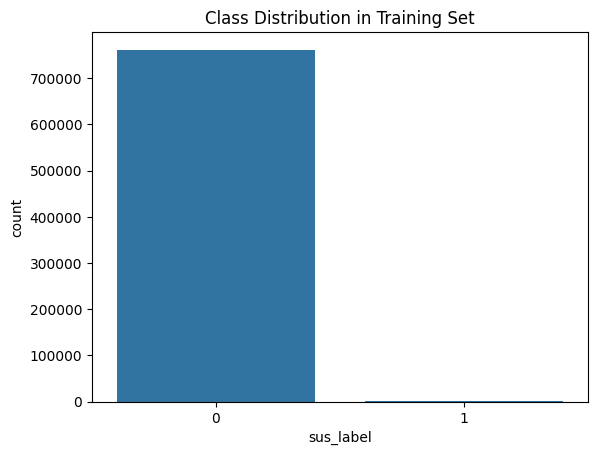

In [4]:

# Displaying the first few rows of the dataset to understand the structure
print("Training Data Preview:")
print(train_df.head())

# Data Summary Statistics
print("\nTraining Data Summary Statistics:")
print(train_df.describe())

# Checking the distribution of the target variable ('sus_label') to see if there is class imbalance
sns.countplot(x='sus_label', data=train_df)
plt.title("Class Distribution in Training Set")
plt.show()

In [5]:
# --- Data Preprocessing ---
print (train_df.shape)
print (test_df.shape)
print (val_df.shape)
train_df = train_df.dropna(subset=['sus_label'])
test_df = test_df.dropna(subset=['sus_label'])
val_df = val_df.dropna(subset=['sus_label'])
print (train_df.shape)
print (test_df.shape)
print (val_df.shape)
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
X_val = val_df.iloc[:, :-1]
y_val = val_df.iloc[:, -1]

# Standardize the data to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# --- Convert data to PyTorch tensors ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# --- Create DataLoader for batching ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


(763144, 8)
(188967, 8)
(188967, 8)
(763144, 8)
(188967, 8)
(188967, 8)


In [6]:
class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.model(x)



In [7]:
# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=3.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # Compute binary cross-entropy loss
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute pt (probability of the true class)
        pt = torch.exp(-BCE_loss)

        # Compute Focal Loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = Net(input_size)
criterion = FocalLoss(alpha=0.25, gamma=2.0)  # Use Focal Loss
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)

# Initialize metrics
train_acc = Accuracy(task="binary")
val_acc = Accuracy(task="binary")
test_acc = Accuracy(task="binary")

train_precision = Precision(task="binary")
val_precision = Precision(task="binary")
test_precision = Precision(task="binary")

train_recall = Recall(task="binary")
val_recall = Recall(task="binary")
test_recall = Recall(task="binary")

train_f1 = F1Score(task="binary")
val_f1 = F1Score(task="binary")
test_f1 = F1Score(task="binary")

train_auroc = AUROC(task="binary")
val_auroc = AUROC(task="binary")
test_auroc = AUROC(task="binary")


In [8]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc.reset()
    train_precision.reset()
    train_recall.reset()
    train_f1.reset()
    train_auroc.reset()

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Compute training metrics
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        train_acc.update(preds, batch_y)
        train_precision.update(preds, batch_y)
        train_recall.update(preds, batch_y)
        train_f1.update(preds, batch_y)
        train_auroc.update(torch.sigmoid(outputs), batch_y)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_acc.reset()
    val_precision.reset()
    val_recall.reset()
    val_f1.reset()
    val_auroc.reset()

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            # Compute validation metrics
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            val_acc.update(preds, batch_y)
            val_precision.update(preds, batch_y)
            val_recall.update(preds, batch_y)
            val_f1.update(preds, batch_y)
            val_auroc.update(torch.sigmoid(outputs), batch_y)

    # Compute metrics
    train_accuracy = train_acc.compute()
    val_accuracy = val_acc.compute()
    train_precision_val = train_precision.compute()
    val_precision_val = val_precision.compute()
    train_recall_val = train_recall.compute()
    val_recall_val = val_recall.compute()
    train_f1_val = train_f1.compute()
    val_f1_val = val_f1.compute()
    train_auroc_val = train_auroc.compute()
    val_auroc_val = val_auroc.compute()

    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Train Precision: {train_precision_val:.4f}, "
          f"Train Recall: {train_recall_val:.4f}, "
          f"Train F1: {train_f1_val:.4f}, "
          f"Train AUROC: {train_auroc_val:.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, "
          f"Val Precision: {val_precision_val:.4f}, "
          f"Val Recall: {val_recall_val:.4f}, "
          f"Val F1: {val_f1_val:.4f}, "
          f"Val AUROC: {val_auroc_val:.4f}")


Epoch 1/10: Train Loss: 0.0008, Train Accuracy: 0.9994, Train Precision: 0.8813, Train Recall: 0.7258, Train F1: 0.7960, Train AUROC: 0.9543, Val Loss: 0.0007, Val Accuracy: 1.0000, Val Precision: 1.0000, Val Recall: 0.9885, Val F1: 0.9942, Val AUROC: 0.9890
Epoch 2/10: Train Loss: 0.0010, Train Accuracy: 0.9995, Train Precision: 0.8923, Train Recall: 0.7636, Train F1: 0.8229, Train AUROC: 0.9657, Val Loss: 0.0009, Val Accuracy: 1.0000, Val Precision: 1.0000, Val Recall: 0.9885, Val F1: 0.9942, Val AUROC: 0.9922
Epoch 3/10: Train Loss: 0.0014, Train Accuracy: 0.9995, Train Precision: 0.8987, Train Recall: 0.7620, Train F1: 0.8247, Train AUROC: 0.9568, Val Loss: 0.0002, Val Accuracy: 1.0000, Val Precision: 1.0000, Val Recall: 0.9885, Val F1: 0.9942, Val AUROC: 0.9958
Epoch 4/10: Train Loss: 0.0015, Train Accuracy: 0.9995, Train Precision: 0.8937, Train Recall: 0.7620, Train F1: 0.8226, Train AUROC: 0.9597, Val Loss: 0.0003, Val Accuracy: 1.0000, Val Precision: 1.0000, Val Recall: 0.9885

Test Loss: 0.0616, Test Accuracy: 0.9448, Test Precision: 1.0000, Test Recall: 0.9391, Test F1: 0.9686, Test AUROC: 0.9894


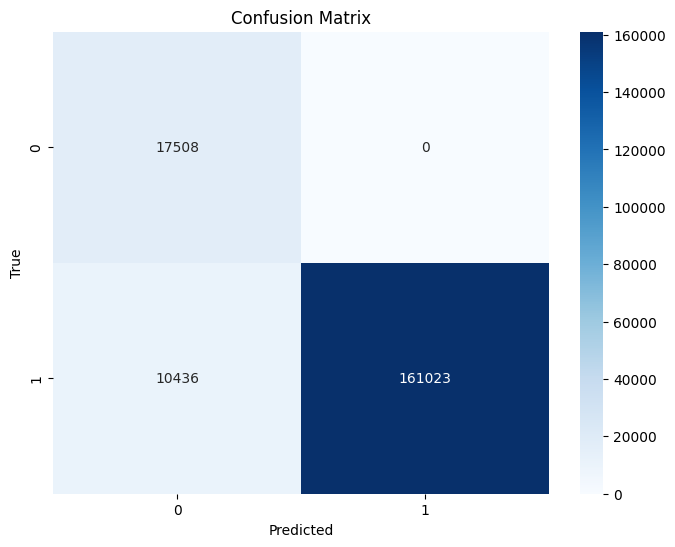

In [9]:
# --- Testing the Model ---
model.eval()  # Set the model to evaluation mode for testing
test_loss = 0.0
test_acc.reset()
test_precision.reset()
test_recall.reset()
test_f1.reset()
test_auroc.reset()
# Store all predictions and labels for confusion matrix
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        # Compute test metrics
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        test_acc.update(preds, batch_y)
        test_precision.update(preds, batch_y)
        test_recall.update(preds, batch_y)
        test_f1.update(preds, batch_y)
        test_auroc.update(torch.sigmoid(outputs), batch_y)
        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
# Compute test metrics
test_accuracy = test_acc.compute()
test_precision_val = test_precision.compute()
test_recall_val = test_recall.compute()
test_f1_val = test_f1.compute()
test_auroc_val = test_auroc.compute()
# Print test results
print(f"Test Loss: {test_loss / len(test_loader):.4f}, "
      f"Test Accuracy: {test_accuracy:.4f}, "
      f"Test Precision: {test_precision_val:.4f}, "
      f"Test Recall: {test_recall_val:.4f}, "
      f"Test F1: {test_f1_val:.4f}, "
      f"Test AUROC: {test_auroc_val:.4f}")
# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
# --- Plot Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()